# IGRINS CA1 R3 blaze model

Here we finally get to our desired result: the blaze envelope at R3.

In [1]:
import matplotlib.pyplot as plt
import numpy as np

%config InlineBackend.figure_format='retina'

### Fixed physical properties

In [23]:
sigma = 64.9 #64.9 is M band, 27.36 is IGRINS# micron

In [24]:
groove_top_width = 109.90-sigma # micron

In [25]:
blaze_angle_radians = np.arctan(3) # radians
blaze_angle_degrees = np.degrees(blaze_angle_radians)
blaze_angle_degrees

71.56505117707799

Assume testing in back-surface reflection in visible light!

In [26]:
wavelength_micron = 0.632 # micron

In [27]:
beam_size_mm = 5 # mm
beam_size_micron = beam_size_mm*1000.0

Fix the angle of incidence for now.

In [28]:
theta_i_degrees = 73.0
theta_i_radians = np.radians(theta_i_degrees)

### Set the angular sampling

We want a number that has about 10 steps per beamsize.

In [29]:
degrees_per_step = 0.002 # degrees

In [30]:
angular_grid_degrees = np.arange(-90, 90, degrees_per_step)
angular_grid_radians = np.radians(angular_grid_degrees)

In [31]:
max_m = np.floor(2 * sigma / wavelength_micron)
m_vector = np.arange(-max_m, max_m+1, 1)

Note that we are including diffraction orders like $m=-52$ that only exist for some incidence angles.  That's OK! We are being overly-inclusive in case we go to extreme values of $\theta_i$ that reveal some of those presently-unphysical orders.

### Calculate the groove scarp facet diffraction

Compute the angles of the peak of diffraction for the input wavelength.  

$\theta_m = \arcsin{\left( \sin\theta_i -\frac{m\lambda}{\sigma}\right )}$  

In [32]:
%%capture
theta_m_radians = np.arcsin(np.sin(theta_i_radians) - m_vector*(wavelength_micron)/sigma)
theta_m_degrees = np.degrees(theta_m_radians)

In [33]:
finite_mask = np.isfinite(theta_m_radians)

In [34]:
theta_m_column = theta_m_radians[np.newaxis, :]

### Visualize the unblazed diffraction from all of these orders

We need to shift-and-sum the flux contribution from all of our diffraction orders.

Each order has a mirror-like diffraction centered on its $\theta_m$:

$$\frac{I_m(\boldsymbol{\theta})}{I_0} = \operatorname{sinc}^2 \left[ \frac{d \pi}{\lambda} \sin{(\boldsymbol{\theta}-\theta_m)}\right]$$

$$\mathrm{"LHS"} = \mathrm{"RHS"}$$

In [35]:
rhs_argument = (beam_size_micron*np.pi/(wavelength_micron)*
                np.sin(angular_grid_radians[:, np.newaxis]-theta_m_column))

There's technically a foreshortening term associated with non-normal-incidence beamsize projection effects.   
Ignore it for now!

$$\frac{I(\boldsymbol{\theta})}{I_0} = \sum_{m_\mathrm{min}}^{m_\mathrm{max}} \operatorname{sinc}^2 \left[ \frac{d \pi}{\lambda} \sin{(\boldsymbol{\theta}-\theta_m)}\right]$$

In [36]:
rhs = np.nan_to_num(np.sinc(rhs_argument)**2, nan=0.0)

In [37]:
unblazed_groove_top_diffraction = np.sum(rhs, axis=1)

### Visualize the *blazed* diffraction from all of these orders

Each order has a mirror-like diffraction centered on its $\theta_m$, calculated above.

In [38]:
def foreshortened_groove(sigma, groove_top_width, incidence_angle):
    """ The size of the illuminated groove 
    
    Note:
    -----
    Function formerly known as "beam_waist", renamed to disambiguate
    
    Parameters:
    -----------
    sigma: The groove spacing or groove pitch (micron)
    groove_top_width: The groove top or 'dam' unique to Si grating
        development, they cause shadowing (micron)
    incidence_angle: The input angle, as measured from the 
        grating normal (degrees)
    """
    
    A_micron = sigma - groove_top_width
    incidence_angle_radians = np.radians(incidence_angle)
    
    output = A_micron * np.cos(incidence_angle_radians)
    return output

In [39]:
d_term = foreshortened_groove(sigma, groove_top_width, theta_i_degrees)
d_term

5.818196923982463

In [40]:
blaze_modulation = np.sinc((d_term*np.pi/(wavelength_micron)*
                np.sin(angular_grid_radians + theta_i_radians)))**2

Again, there's an incidence-angle foreshortening effect here...

In [41]:
blazed_groove_top_diffraction = blaze_modulation * unblazed_groove_top_diffraction

In [70]:


print(np.amax(blazed_groove_top_diffraction)) #This is the normalized brightness in the brightest pixel

np.argmax(blazed_groove_top_diffraction) #This is the index of the order(?) that is brightest

print(int(m)) #This is the order that is brightest?


0.5732809657458073
205


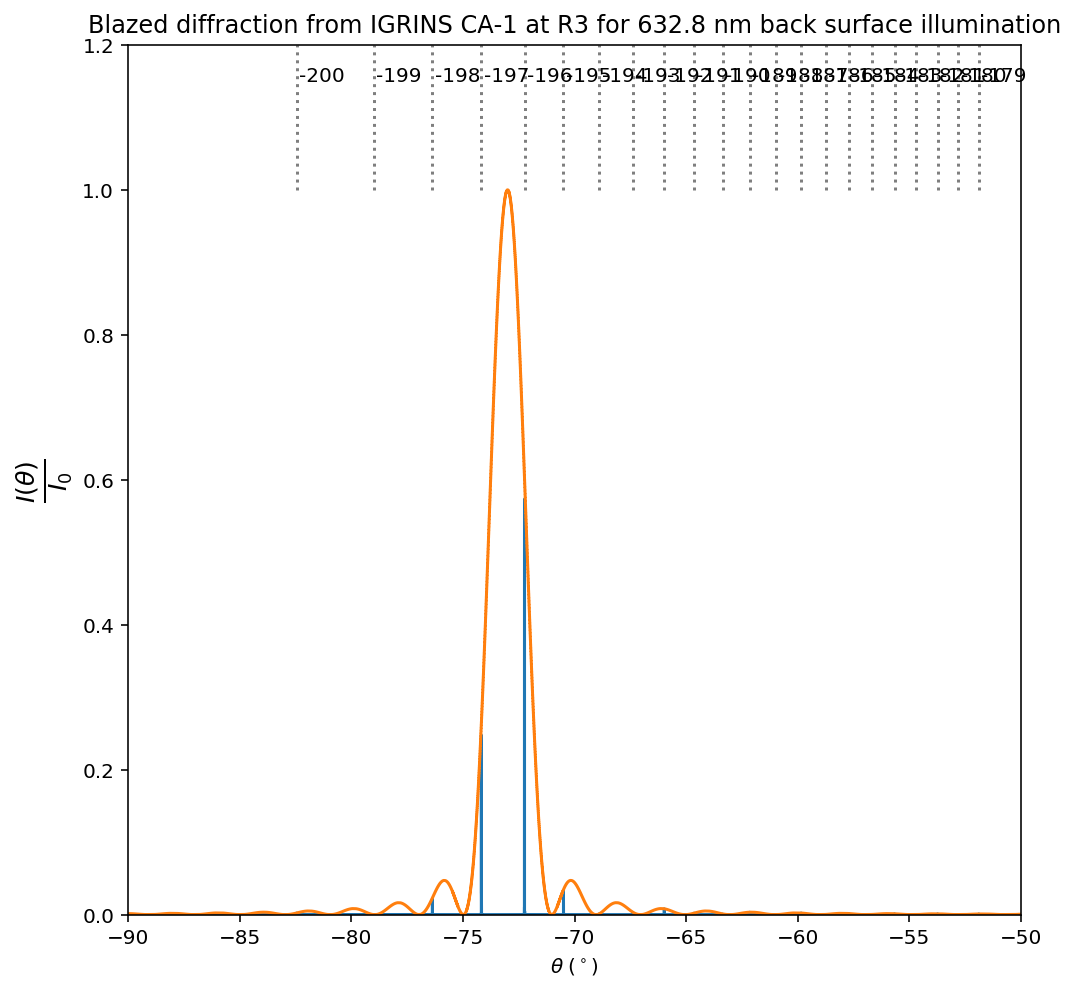

In [42]:
plt.figure(figsize=(8, 8))
plt.step(angular_grid_degrees, blazed_groove_top_diffraction, where='mid')
plt.step(angular_grid_degrees, blaze_modulation, where='mid')

x_lo, x_hi = (-90, -50)
plt.xlim(x_lo, x_hi)
plt.ylim(0, 1.2)

for m, theta_m in zip(m_vector, theta_m_degrees):
    if np.isfinite(theta_m) & (theta_m>x_lo) & (theta_m < x_hi-1):
        plt.text(theta_m+0.1, 1.15, "{:d}".format(-int(m)), rotation='horizontal')
        plt.plot([theta_m, theta_m], [1.0, 1.2], color='k', alpha=0.5, 
                 linestyle='dotted')

plt.xlabel(r'$\theta \; (^\circ)$')
plt.ylabel(r'$\frac{I(\theta)}{I_0}$', fontsize=18)
plt.title('Blazed diffraction from IGRINS CA-1 at R3 for 632.8 nm back surface illumination'.format(beam_size_mm) );

plt.rcParams['axes.facecolor']='white'
plt.rcParams['savefig.facecolor']='white'

plt.savefig('../../figures/IGRINS_CA1_R3_blaze.png', dpi=300, bbox_inches='tight');

Let's look at the whole range in log space

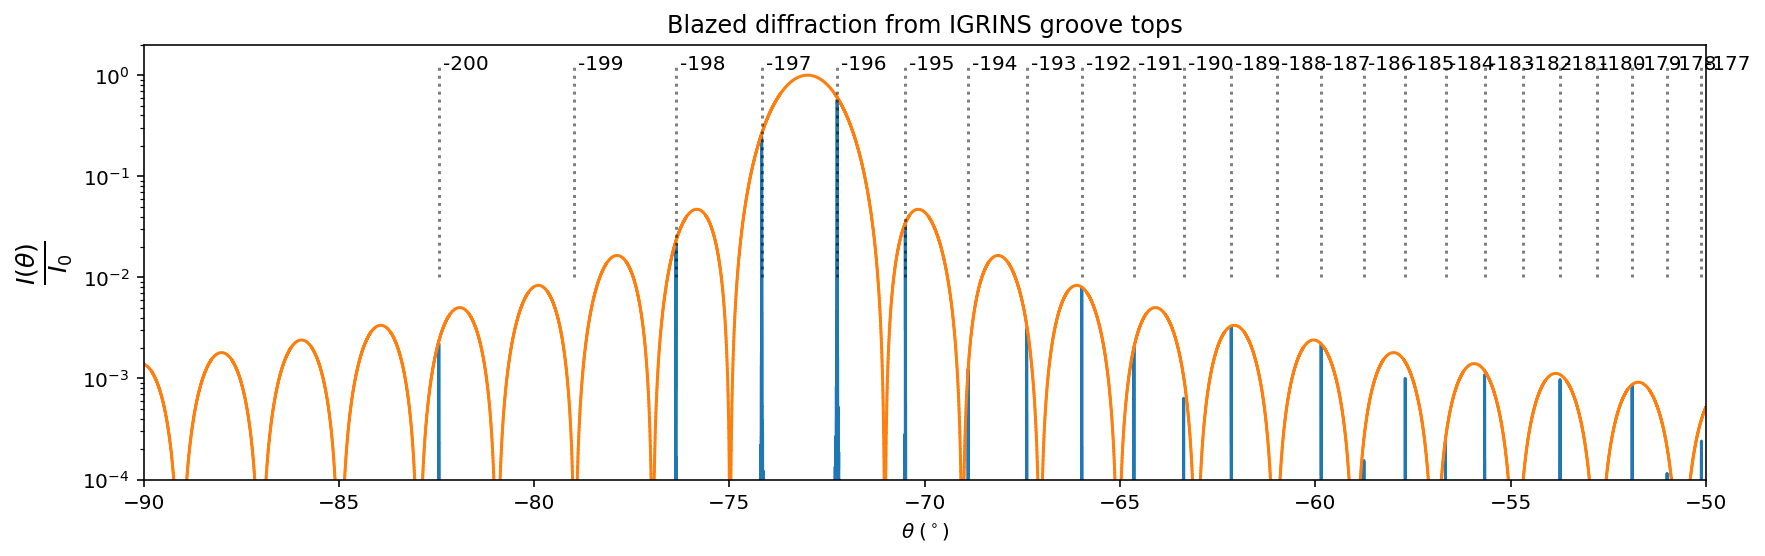

In [43]:
plt.figure(figsize=(14, 4))
plt.step(angular_grid_degrees, blazed_groove_top_diffraction)
plt.step(angular_grid_degrees, blaze_modulation)

x_lo, x_hi = (-90, -50)
plt.xlim(x_lo, x_hi)
plt.ylim(1e-4, 2)
plt.yscale('log')

for m, theta_m in zip(m_vector, theta_m_degrees):
    if np.isfinite(theta_m) & (theta_m>x_lo) & (theta_m < x_hi) & (np.mod(m, 1) ==0):
        plt.text(theta_m+0.1, 1.15, "{:d}".format(-int(m)), rotation='horizontal')
        plt.plot([theta_m, theta_m], [0.01, 1.2], color='k', alpha=0.5, 
                 linestyle='dotted')

plt.xlabel(r'$\theta \; (^\circ)$')
plt.ylabel(r'$\frac{I(\theta)}{I_0}$', fontsize=18)
plt.title('Blazed diffraction from IGRINS groove tops'.format(beam_size_mm) );

Awesome!  Appears correct!